# Intro

I'm trying to learn the very basics with this exercise. My goal is to train a linear regression model with a subset of columns from this interesting dataset in order to predict the value of a used car.

Any help or advice is welcome!!!

### Changelist

* removed feature regularization for Linear regression
* corrected Y values skewing
* added L2 regularized LR model
* added a neural net model
* added chart to visualize prediction samples

In [1]:
import pandas as pd

import matplotlib.pyplot as plt
import numpy as np
from sklearn import datasets, linear_model, preprocessing, svm
from sklearn.preprocessing import StandardScaler, Normalizer
import math
import matplotlib

# Preparing data

## Reading from file

Just reading the file and printing some lines.

In [2]:
df = pd.read_csv('autos.csv.gz', sep=',', header=0, compression='gzip',encoding='cp1252')
df.head()

,dateCrawled,name,seller,offerType,price,abtest,vehicleType,yearOfRegistration,gearbox,powerPS,model,kilometer,monthOfRegistration,fuelType,brand,notRepairedDamage,dateCreated,nrOfPictures,postalCode,lastSeen
0,2016-03-24 11:52:17,Golf_3_1.6,privat,Angebot,480,test,NaN,1993,manuell,0,golf,150000,0,benzin,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,A5_Sportback_2.7_Tdi,privat,Angebot,18300,test,coupe,2011,manuell,190,NaN,125000,5,diesel,audi,ja,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,"Jeep_Grand_Cherokee_""Overland""",privat,Angebot,9800,test,suv,2004,automatik,163,grand,125000,8,diesel,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,GOLF_4_1_4__3TÜRER,privat,Angebot,1500,test,kleinwagen,2001,manuell,75,golf,150000,6,benzin,volkswagen,nein,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,Skoda_Fabia_1.4_TDI_PD_Classic,privat,Angebot,3600,test,kleinwagen,2008,manuell,69,fabia,90000,7,diesel,skoda,nein,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


## Cleaning data from outliers and dirty values

Cleaning data from duplicates, NaNs and selecting reasonable ranges for columns


In [3]:
print("Too new: %d" % df.loc[df.yearOfRegistration >= 2017].count()['name'])
print("Too old: %d" % df.loc[df.yearOfRegistration < 1950].count()['name'])
print("Too cheap: %d" % df.loc[df.price < 100].count()['name'])
print("Too expensive: " , df.loc[df.price > 150000].count()['name'])
print("Too few km: " , df.loc[df.kilometer < 5000].count()['name'])
print("Too many km: " , df.loc[df.kilometer > 200000].count()['name'])
print("Too few PS: " , df.loc[df.powerPS < 10].count()['name'])
print("Too many PS: " , df.loc[df.powerPS > 500].count()['name'])
print("Fuel types: " , df['fuelType'].unique())
print("Offer types: " , df['offerType'].unique())
print("Sellers: " , df['seller'].unique())
print("Damages: " , df['notRepairedDamage'].unique())
print("Pics: " , df['nrOfPictures'].unique()) # nrOfPictures : number of pictures in the ad (unfortunately this field contains everywhere a 0 and is thus useless (bug in crawler!) )
print("Postale codes: " , df['postalCode'].unique())
print("Vehicle types: " , df['vehicleType'].unique())

# Cleaning data
valid_models = df.dropna()

#### Removing the duplicates
dedups = valid_models.drop_duplicates(['name','seller','offerType','price','abtest','vehicleType','yearOfRegistration'
                         ,'gearbox','powerPS','model','kilometer','monthOfRegistration','fuelType'
                         ,'notRepairedDamage','postalCode'])

#### Removing the outliers
no_outliers = dedups[
        (valid_models.yearOfRegistration <= 2016) 
      & (valid_models.yearOfRegistration >= 1950) 
      & (valid_models.price >= 100) 
      & (valid_models.price <= 150000) 
      & (valid_models.powerPS >= 10) 
      & (valid_models.powerPS <= 500)]

print("\nData kept for analisys: %d percent of the entire set" % (100 * no_outliers['name'].count() / df['name'].count()))

Too new: 14680
Too old: 289
Too cheap: 13320
Too expensive:  232
Too few km:  0
Too many km:  0
Too few PS:  41040
Too many PS:  835
Fuel types:  ['benzin' 'diesel' nan 'lpg' 'andere' 'hybrid' 'cng' 'elektro']
Offer types:  ['Angebot' 'Gesuch']
Sellers:  ['privat' 'gewerblich']
Damages:  [nan 'ja' 'nein']
Pics:  [0]
Postale codes:  [70435 66954 90480 ..., 38528 38325 31096]
Vehicle types:  [nan 'coupe' 'suv' 'kleinwagen' 'limousine' 'cabrio' 'bus' 'kombi' 'andere']

Data kept for analisys: 65 percent of the entire set


/opt/conda/lib/python3.5/site-packages/ipykernel/__main__.py:32: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


## Selecting only relevant columns

Here I select the columns that I think are useful for determining a car's price.


In [4]:

# only relevant columns
rel_cols = no_outliers[['price'
                        ,'yearOfRegistration'
                        ,'gearbox'
                        ,'powerPS'
                        ,'model'
                        ,'kilometer'
                        ,'fuelType'
                        ,'vehicleType'
                        ,'monthOfRegistration'
                        ,'brand'
                        ,'notRepairedDamage']]
rel_cols.head()

,price,yearOfRegistration,gearbox,powerPS,model,kilometer,fuelType,vehicleType,monthOfRegistration,brand,notRepairedDamage
3,1500,2001,manuell,75,golf,150000,benzin,kleinwagen,6,volkswagen,nein
4,3600,2008,manuell,69,fabia,90000,diesel,kleinwagen,7,skoda,nein
5,650,1995,manuell,102,3er,150000,benzin,limousine,10,bmw,ja
6,2200,2004,manuell,109,2_reihe,150000,benzin,cabrio,8,peugeot,nein
10,2000,2004,manuell,105,3_reihe,150000,benzin,limousine,12,mazda,nein


## Encoding

This part encodes the string fields to numerical values.

In [5]:
labels = ['gearbox', 'notRepairedDamage', 'model', 'brand', 'fuelType', 'vehicleType']
les = {}

for l in labels:
    les[l] = preprocessing.LabelEncoder()
    les[l].fit(rel_cols[l])
    tr = les[l].transform(rel_cols[l]) 
    rel_cols.loc[:, l + '_feat'] = pd.Series(tr, index=rel_cols.index)

df_autos = rel_cols[ ['price'
                        ,'yearOfRegistration'
                        ,'powerPS'
                        ,'kilometer'
                        ,'monthOfRegistration'] 
                    + [x+"_feat" for x in labels]]
print(df_autos.head())
autos = df_autos.values.astype(float)

Y = autos[:,0]
X = autos[:,1:]

print("X", X.shape)
print("Y", Y.shape)


/opt/conda/lib/python3.5/site-packages/pandas/core/indexing.py:288: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/opt/conda/lib/python3.5/site-packages/pandas/core/indexing.py:465: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


    price  yearOfRegistration  powerPS  kilometer  monthOfRegistration  \
3    1500                2001       75     150000                    6   
4    3600                2008       69      90000                    7   
5     650                1995      102     150000                   10   
6    2200                2004      109     150000                    8   
10   2000                2004      105     150000                   12   

    gearbox_feat  notRepairedDamage_feat  model_feat  brand_feat  \
3              1                       1         118          37   
4              1                       1         103          31   
5              1                       0          11           2   
6              1                       1           8          25   
10             1                       1          10          19   

    fuelType_feat  vehicleType_feat  
3               1                 4  
4               3                 4  
5               1               

## Correction

Transforming the right-skewed sale price column.

**TODO**: leave test w/ and w/o correction

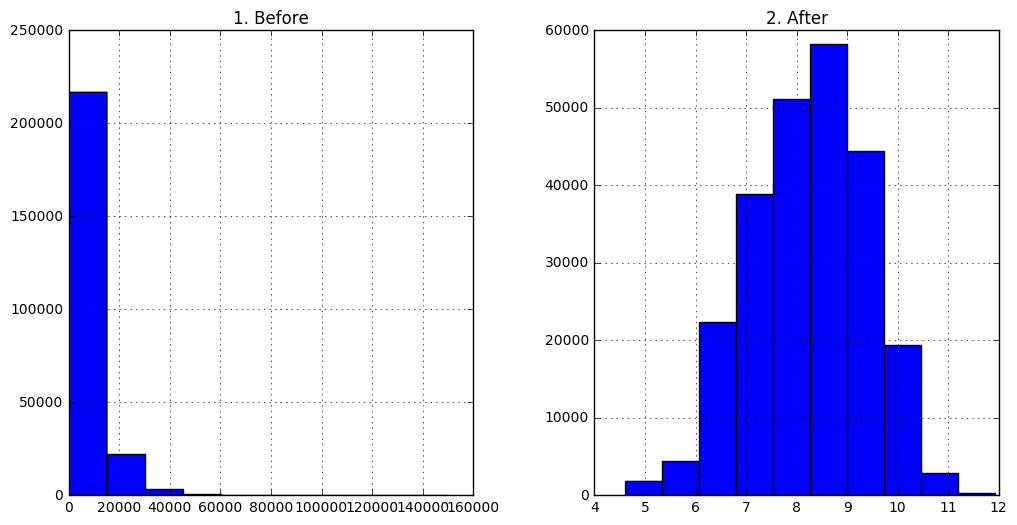

In [6]:
matplotlib.rcParams['figure.figsize'] = (12.0, 6.0)
prices = pd.DataFrame({"1. Before":Y, "2. After":np.log1p(Y)})
prices.hist()

Y = np.log1p(Y)

# Trying out models

Trying with some model from scikit learn: LinearRegression, LR with L2 regularization and a Neural network.

In [18]:
from sklearn.linear_model import Ridge, RidgeCV, ElasticNet, Lasso, LassoCV, LassoLarsCV
from sklearn.model_selection import cross_val_score, train_test_split


def cv_rmse(model, x, y):
    r = np.sqrt(-cross_val_score(model, x, y, scoring="neg_mean_squared_error", cv = 5))
    return r



## Linear Regression

In [19]:
linear = linear_model.LinearRegression()

# Percent of the X array to use as training set. This implies that the rest will be test set
test_size = .2

#Split into train and validation
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=test_size, random_state = 3)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)
linear.fit(X_train, y_train)

# Explained variance score: 1 is perfect prediction
score = linear.score(X_test, y_test)
print('Variance score: %.2f' % score)

print("rmse on train set", cv_rmse(linear, X_train, y_train).mean())
print("rmse on validation set", cv_rmse(linear, X_test, y_test).mean())


(195110, 10) (48778, 10) (195110,) (48778,)
Variance score: 0.68
rmse on train set 0.632516874438
rmse on validation set 0.639555427197


## Predicting samples

In [20]:

def calc_values(model, year, brand, car_model, vehicle, gearbox, fuel, powerPS, km, not_repaired_damage):
    sample = [year
          , powerPS
          , km
          , 1 # month
          , les['gearbox'].transform([gearbox])
          , les['notRepairedDamage'].transform([not_repaired_damage])
          , les['model'].transform([car_model])
          , les['brand'].transform([brand])
          , les['fuelType'].transform([fuel])
          , les['vehicleType'].transform([vehicle])]
    s_predict = np.expm1(model.predict([sample]))
    return s_predict

# [nan 'coupe' 'suv' 'kleinwagen' 'limousine' 'cabrio' 'bus' 'kombi' 'andere']
vw1 = calc_values(linear, 2016, 'volkswagen', 'touran', 'bus', 'manuell', 'diesel', 105, 10000, 'nein')
bmw  = calc_values(linear, 2016, 'bmw', '3er', 'limousine', 'manuell', 'diesel', 150, 10000, 'nein')
fiat  = calc_values(linear, 2016, 'fiat', 'punto', 'kleinwagen', 'manuell', 'benzin', 60, 10000, 'nein')
vw2 = calc_values(linear, 2016, 'volkswagen', 'tiguan', 'suv', 'manuell', 'diesel', 130, 10000, 'nein')

print(vw1)
print(bmw)
print(fiat)
print(vw2)

[ 24547.88933013]
[ 28021.04561071]
[ 10082.71193557]
[ 23878.09002551]


## L1 regularized LR


Variance score: 0.61
kilometer                -0.000009
monthOfRegistration       0.000000
gearbox_feat             -0.000000
notRepairedDamage_feat    0.000000
brand_feat                0.000000
fuelType_feat             0.000000
vehicleType_feat         -0.000000
model_feat                0.000232
powerPS                   0.009325
yearOfRegistration        0.049206
dtype: float64
0.707839916347


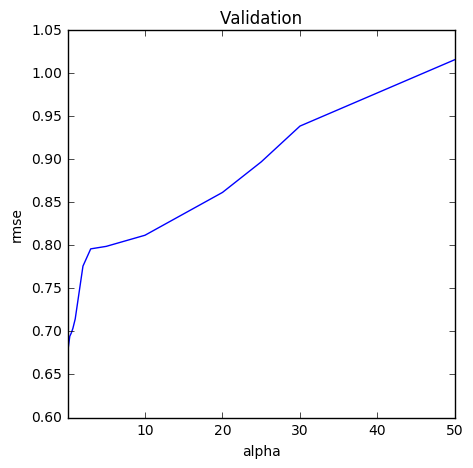

In [34]:

alphas = [0.005,0.05, 0.1, 0.3, 0.5, 0.7, 1, 2, 3, 5, 10, 20, 25, 30, 50]
cv_lasso = [cv_rmse(Lasso(alpha = alpha), X_train, y_train).mean() for alpha in alphas]

cv_lasso = pd.Series(cv_lasso, index = alphas)
cv_lasso.plot(title = "Validation", figsize=(5,5))
plt.xlabel("alpha")
plt.ylabel("rmse")

model_lasso = Lasso(alpha = cv_lasso.min()).fit(X_train, y_train)

# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % model_lasso.score(X_test, y_test))

coef = pd.Series(model_lasso.coef_, index = df_autos.iloc[:,1:].columns)

imp_coef = pd.concat([coef.sort_values()])

print(imp_coef)

print(np.sqrt(np.mean((y_test - model_lasso.predict(X_test))**2)))


In [26]:
vw1 = calc_values(model_lasso, 2016, 'volkswagen', 'touran', 'bus', 'manuell', 'diesel', 105, 10000, 'nein')
bmw  = calc_values(model_lasso, 2016, 'bmw', '3er', 'limousine', 'manuell', 'diesel', 150, 10000, 'nein')
fiat  = calc_values(model_lasso, 2016, 'fiat', 'punto', 'kleinwagen', 'manuell', 'benzin', 60, 10000, 'nein')
vw2 = calc_values(model_lasso, 2016, 'volkswagen', 'tiguan', 'suv', 'manuell', 'diesel', 130, 10000, 'nein')

print(vw1)
print(bmw)
print(fiat)
print(vw2)

[ 16610.43495931]
[ 24063.59282806]
[ 10804.11801494]
[ 20957.00514208]


## L2 regularized LR

Variance score: 0.68
gearbox_feat             -0.062801
vehicleType_feat         -0.040712
model_feat               -0.000271
kilometer                -0.000009
brand_feat                0.003133
monthOfRegistration       0.005054
powerPS                   0.008632
yearOfRegistration        0.056789
fuelType_feat             0.151817
notRepairedDamage_feat    0.751482
dtype: float64
0.639334838313


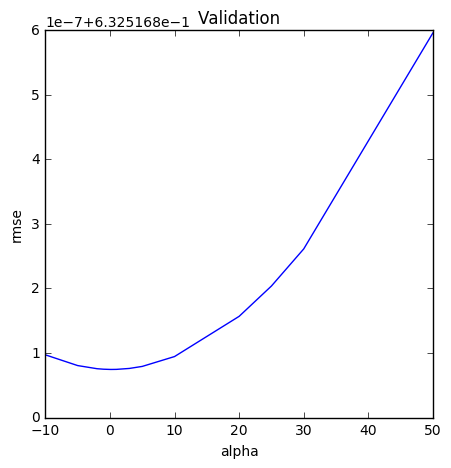

In [31]:

alphas = [-10, -5, -2, -1, 0, 0.005,0.05, 0.1, 0.3, 1, 3, 5, 10, 20, 25, 30, 50]
cv_ridge = [cv_rmse(Ridge(alpha = alpha), X_train, y_train).mean() for alpha in alphas]

cv_ridge = pd.Series(cv_ridge, index = alphas)
cv_ridge.plot(title = "Validation", figsize=(5,5))
plt.xlabel("alpha")
plt.ylabel("rmse")

model_ridge = Ridge(alpha = cv_ridge.min()).fit(X_train, y_train)

# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % model_ridge.score(X_test, y_test))

coef = pd.Series(model_ridge.coef_, index = df_autos.iloc[:,1:].columns)

imp_coef = pd.concat([coef.sort_values()])

print(imp_coef)

print(np.sqrt(np.mean((y_test - model_ridge.predict(X_test))**2)))


In [15]:
vw1 = calc_values(model_ridge, 2016, 'volkswagen', 'touran', 'bus', 'manuell', 'diesel', 105, 10000, 'nein')
bmw  = calc_values(model_ridge, 2016, 'bmw', '3er', 'limousine', 'manuell', 'diesel', 150, 10000, 'nein')
fiat  = calc_values(model_ridge, 2016, 'fiat', 'punto', 'kleinwagen', 'manuell', 'benzin', 60, 10000, 'nein')
vw2 = calc_values(model_ridge, 2016, 'volkswagen', 'tiguan', 'suv', 'manuell', 'diesel', 130, 10000, 'nein')

print(vw1)
print(bmw)
print(fiat)
print(vw2)

[ 24547.87387523]
[ 28021.04106493]
[ 10082.7060047]
[ 23878.09077935]


## Lasso linear model with iterative fitting along a regularization path


Variance score: 0.12
kilometer                -0.000005
yearOfRegistration        0.000000
powerPS                   0.000000
monthOfRegistration       0.000000
gearbox_feat             -0.000000
notRepairedDamage_feat    0.000000
model_feat               -0.000000
brand_feat               -0.000000
fuelType_feat             0.000000
vehicleType_feat         -0.000000
dtype: float64
1.0677091279


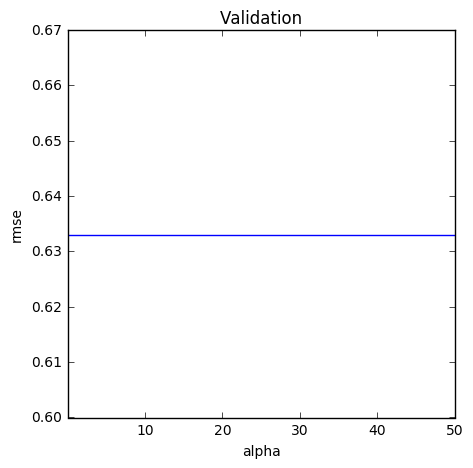

In [38]:

alphas = [0.005,0.05, 0.1, 0.3, 1, 3, 5, 10, 20, 25, 30, 50]
cv_lassocv = [cv_rmse(LassoCV(alphas = alphas), X_train, y_train).mean() for alpha in alphas]

cv_lassocv = pd.Series(cv_lassocv, index = alphas)
cv_lassocv.plot(title = "Validation", figsize=(5,5))
plt.xlabel("alpha")
plt.ylabel("rmse")

model_lassocv = LassoCV(cv_lassocv.min()).fit(X_train, y_train)

# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % model_lassocv.score(X_test, y_test))

coef = pd.Series(model_lassocv.coef_, index = df_autos.iloc[:,1:].columns)

imp_coef = pd.concat([coef.sort_values()])

print(imp_coef)

print(np.sqrt(np.mean((y_test - model_lassocv.predict(X_test))**2)))


In [39]:
vw1 = calc_values(model_lassocv, 2016, 'volkswagen', 'touran', 'bus', 'manuell', 'diesel', 105, 10000, 'nein')
bmw  = calc_values(model_lassocv, 2016, 'bmw', '3er', 'limousine', 'manuell', 'diesel', 150, 10000, 'nein')
fiat  = calc_values(model_lassocv, 2016, 'fiat', 'punto', 'kleinwagen', 'manuell', 'benzin', 60, 10000, 'nein')
vw2 = calc_values(model_lassocv, 2016, 'volkswagen', 'tiguan', 'suv', 'manuell', 'diesel', 130, 10000, 'nein')

print(vw1)
print(bmw)
print(fiat)
print(vw2)

[ 6458.45194932]
[ 6458.45194932]
[ 6458.45194932]
[ 6458.45194932]
